## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout,Flatten, MaxPooling2D

## Loadinf the dataset

In [3]:
TRAIN_DIR = '/kaggle/input/facial-expression-dataset/train/train/'
TEST_DIR = '/kaggle/input/facial-expression-dataset/test/test/'

In [4]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory,label,filename)
            image_paths.append(image_path)
            labels.append(label)
        print(label,'Completed')
        
    return image_paths,labels

In [5]:
# Converting into dataframe
train = pd.DataFrame()
train['image'],train['label'] = load_dataset(TRAIN_DIR)
# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/train/...,sad
1,/kaggle/input/facial-expression-dataset/train/...,angry
2,/kaggle/input/facial-expression-dataset/train/...,happy
3,/kaggle/input/facial-expression-dataset/train/...,neutral
4,/kaggle/input/facial-expression-dataset/train/...,sad


In [6]:
test = pd.DataFrame()
test['image'],test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


## Exploratory Data Analysis

<AxesSubplot:xlabel='label', ylabel='count'>

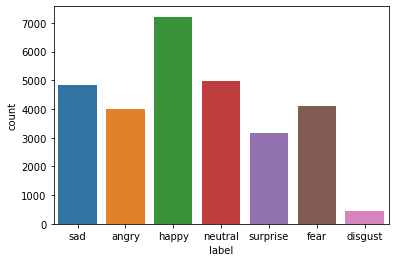

In [7]:
seaborn.countplot(train['label'])

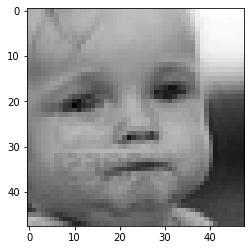

In [8]:
from PIL import Image
img = Image.open(train['image'][25])
plt.imshow(img,cmap='gray');

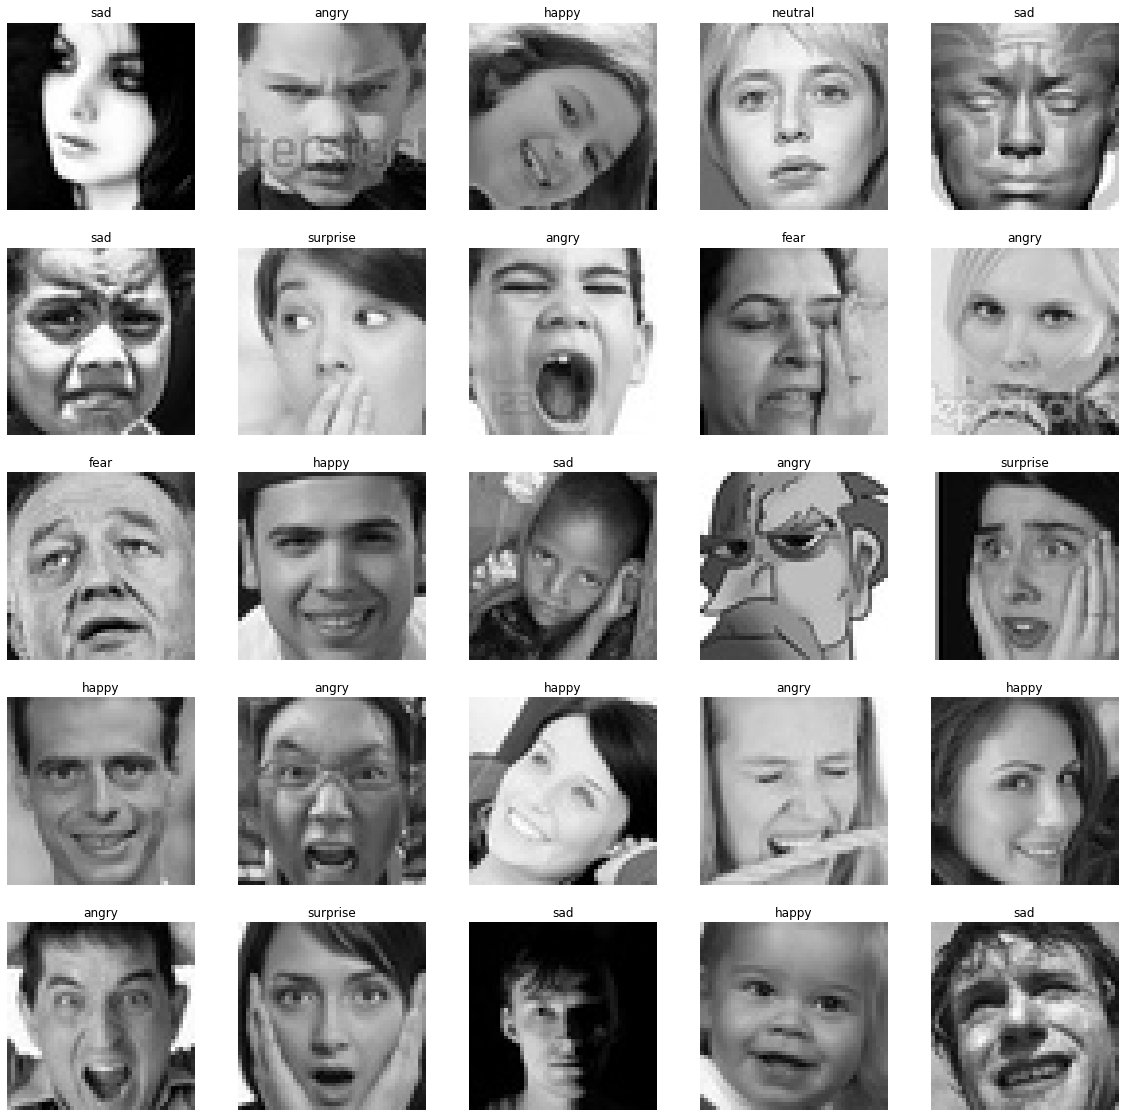

In [9]:
# Displaying grid of images
from keras.preprocessing.image import load_img

plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features  = features.reshape(len(features),48,48,1)
    return features

In [11]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [12]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
# saving the features

import pickle
WORKING_DIR = '/kaggle/working'

In [14]:
# storing features in pickle
pickle.dump(train_features, open(os.path.join(WORKING_DIR, 'train_features'), 'wb'))
pickle.dump(test_features, open(os.path.join(WORKING_DIR, 'test_features'), 'wb'))

In [15]:
# loading features from pickle
with open(os.path.join(WORKING_DIR, 'train_features'), 'rb') as f:
    train_features = pickle.load(f)
    
with open(os.path.join(WORKING_DIR, 'test_features'), 'rb') as f:
    test_features = pickle.load(f)

In [16]:
## NORMALIZING THE IMAGES
x_train = train_features/255.0
x_test = test_features/255.0

In [17]:
## CONVERTING LABELS TO INTEGERS

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [18]:
y_train[0]

5

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [21]:
## CONFIGURATION
input_shape = (48,48,1)
output_class = 7

## Model Creation

In [22]:
model = Sequential()
# CONVOLUTIONAL LAYER
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# FULLY CONNECTED LAYER
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# OUTPUT LAYER
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

2023-01-29 20:29:47.090126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 20:29:47.196003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 20:29:47.196827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 20:29:47.199609: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         1

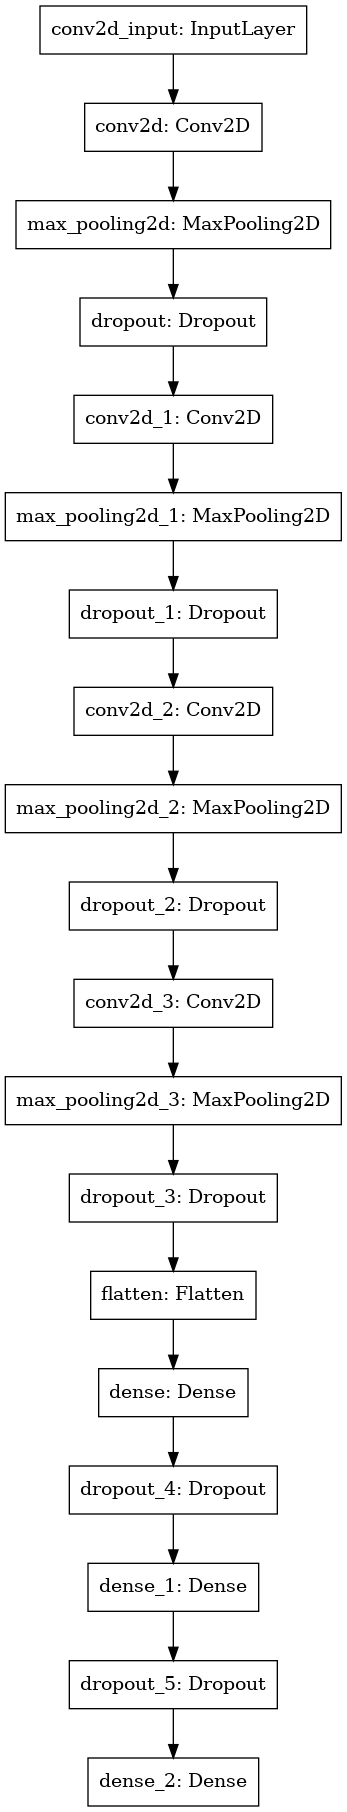

In [24]:
# Plotting the model

from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
history = model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test))

2023-01-29 20:29:51.749533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-29 20:29:53.300654: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - 15s 31ms/step - loss: 1.8232 - accuracy: 0.2474 - val_loss: 1.8146 - val_accuracy: 0.2471
Epoch 2/100
225/225 [==============================] - 6s 28ms/step - loss: 1.8139 - accuracy: 0.2511 - val_loss: 1.8048 - val_accuracy: 0.2542
Epoch 3/100
225/225 [==============================] - 6s 28ms/step - loss: 1.7842 - accuracy: 0.2633 - val_loss: 1.7206 - val_accuracy: 0.2899
Epoch 4/100
225/225 [==============================] - 6s 28ms/step - loss: 1.6951 - accuracy: 0.3083 - val_loss: 1.5632 - val_accuracy: 0.3840
Epoch 5/100
225/225 [==============================] - 6s 28ms/step - loss: 1.5752 - accuracy: 0.3819 - val_loss: 1.4389 - val_accuracy: 0.4234
Epoch 6/100
225/225 [==============================] - 6s 28ms/step - loss: 1.4797 - accuracy: 0.4234 - val_loss: 1.3598 - val_accuracy: 0.4762
Epoch 7/100
225/225 [==============================] - 6s 28ms/step - loss: 1.4226 - accuracy: 0.4494 - val_loss: 1.3101 - val_accuracy: 0.4950
Epo

## Plotting the results

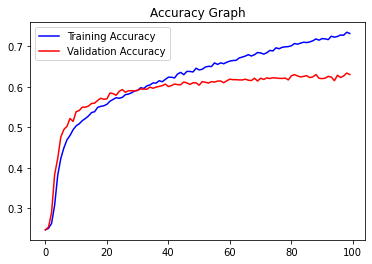

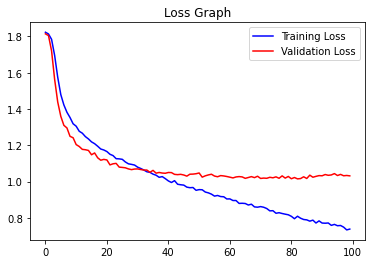

In [26]:
## ACCURACY AND LOSS GRAPH

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Testing

In [27]:
import random

Original Output: happy
Predicted Output: sad


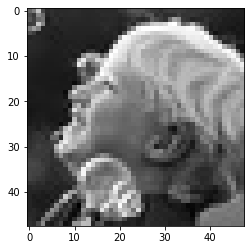

In [28]:
## TEST 1

image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fear
Predicted Output: fear


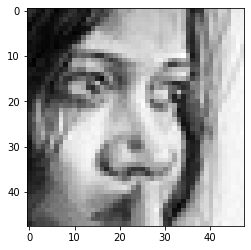

In [29]:
## TEST 2

image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
Predicted Output: neutral


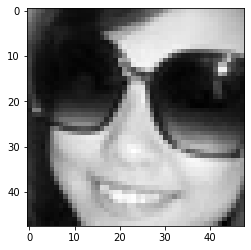

In [30]:
## TEST 3

image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');